In [18]:
import sys, time
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from aotools.functions import phaseFromZernikes

sys.path.append(str('/home/travis/Projects'))

from slmOptim.patternSLM import patterns as pt
from slmOptim.optimization.init_experiment import InitExperiment
from slmOptim.optimization.iteration_algorithms import ZernikePolynomials
from slmOptim.patternSLM.patterns import GaussPatternGenerator
from slmOptim.optimization import cost_functions

ImportError: The wxPython module is required to run this program.

### Define parameters

In [7]:
# Define observation window on camera
roi_size = 100
off = (10, -47 )

# Define camera macropixel, this is defined by the measured speckel grain
bins = 1

# Define camera acquisition parameters
exposure_time = 10
gain = 1
timeout= 100

# init.close_cam()


### Initialize experiment 
#### camera and slm


Connected to 10.42.0.234 on 9999
(104, 104)


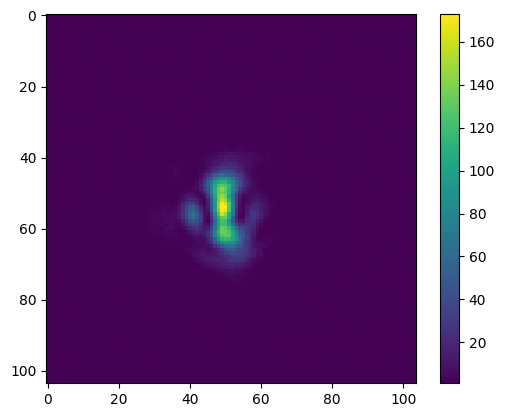

In [8]:
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
slm = init.init_slm()

check the mode to optimize

(104, 104)


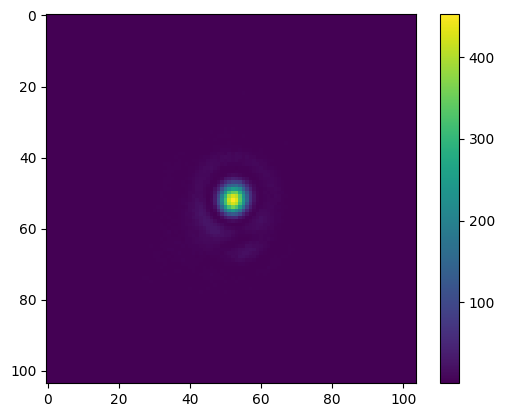

In [21]:
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()

print(frame.shape)

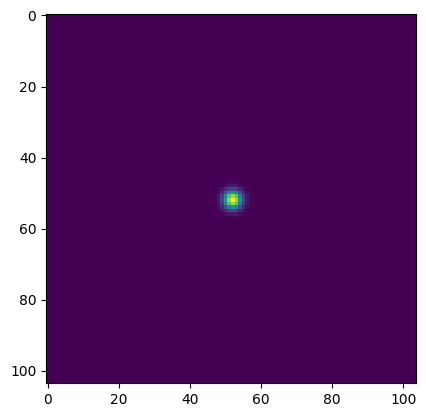

In [32]:
plt.imshow(amp)

In [20]:
# define how many polynomials to use
num = 15

# instantiate zernike class
zern = ZernikePolynomials(slm, 
                           camera,
                           num_of_zernike_coeffs=num, 
                           slm_calibration_pixel=112)

# define cost function and pass it to the object
# cost_fun = lambda x: cost_functions.snr(x, 5, (-1, -2))
gauss = GaussPatternGenerator(N=104, w0=5e-4)
amp, _ = gauss[0]
cost_fun = lambda x: cost_functions.corr_coef(x, amp)

zern.register_callback(cost_fun)

# run algorithm
mask, coeffs, cost, frames = zern.run()

# load optimized mask to SLM
slm.sendArray(mask)


  0%|          | 0/15 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 0:   7%|▋         | 1/15 [00:03<00:55,  3.99s/it, Cost=0.675]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 1:  13%|█▎        | 2/15 [00:08<00:52,  4.00s/it, Cost=0.376]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 2:  20%|██        | 3/15 [00:12<00:48,  4.02s/it, Cost=0.563]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 3:  27%|██▋       | 4/15 [00:16<00:44,  4.02s/it, Cost=0.833]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 4:  33%|███▎      | 5/15 [00:20<00:40,  4.03s/it, Cost=0.832]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 5:  40%|████      | 6/15 [00:24<00:36,  4.04s/it, Cost=0.925]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 6:  47%|████▋     | 7/15 [00:28<00:32,  4.05s/it, Cost=0.92] 

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 7:  53%|█████▎    | 8/15 [00:32<00:28,  4.05s/it, Cost=0.924]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 8:  60%|██████    | 9/15 [00:36<00:24,  4.05s/it, Cost=0.923]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 9:  67%|██████▋   | 10/15 [00:40<00:20,  4.06s/it, Cost=0.925]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 10:  73%|███████▎  | 11/15 [00:44<00:16,  4.06s/it, Cost=0.916]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 11:  80%|████████  | 12/15 [00:48<00:12,  4.06s/it, Cost=0.926]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 12:  87%|████████▋ | 13/15 [00:52<00:08,  4.07s/it, Cost=0.923]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 13:  93%|█████████▎| 14/15 [00:56<00:04,  4.06s/it, Cost=0.924]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted


Iteration #: 14: 100%|██████████| 15/15 [01:00<00:00,  4.05s/it, Cost=0.924]

Data transmitted
Data transmitted


1

In [29]:
import pickle
with open('optimize_aberrations.pkl', 'wb') as fp:
    pickle.dump((mask, coeffs, cost, frames), fp)
    


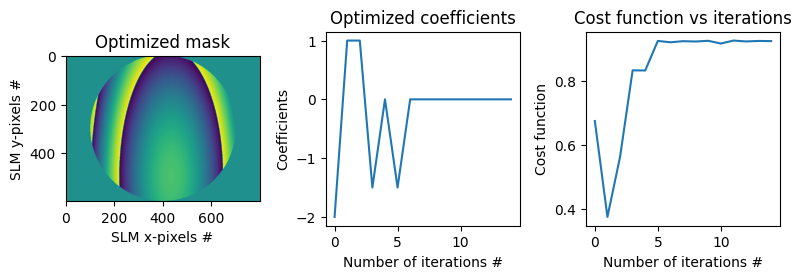

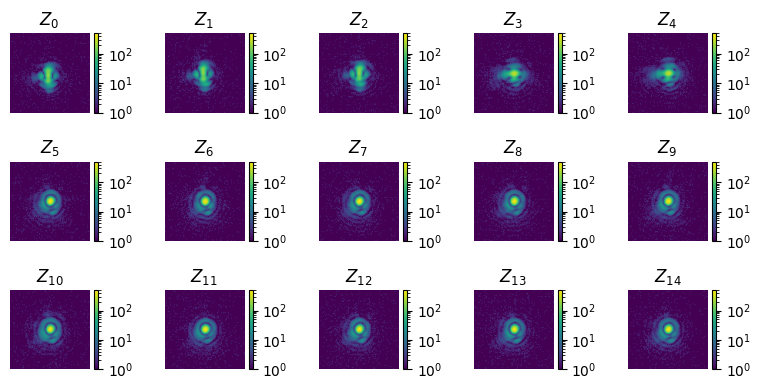

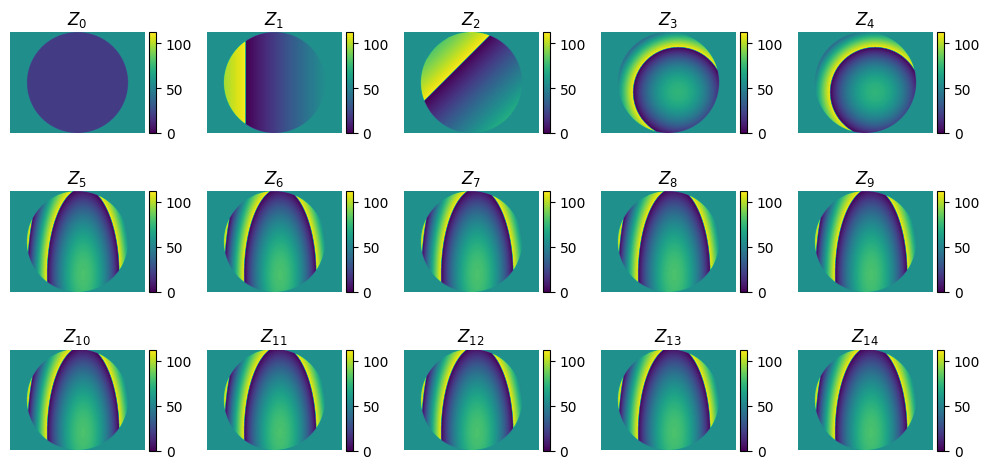

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
axs[0].imshow(mask)
axs[0].set_title("Optimized mask")
axs[0].set_xlabel("SLM x-pixels #")
axs[0].set_ylabel("SLM y-pixels #")


axs[1].plot(coeffs)
axs[1].set_title("Optimized coefficients")
axs[1].set_xlabel("Number of iterations #")
axs[1].set_ylabel("Coefficients")
axs[1].set_box_aspect(1)


axs[2].plot(cost)
axs[2].set_title("Cost function vs iterations")
axs[2].set_xlabel("Number of iterations #")
axs[2].set_ylabel("Cost function")
axs[2].set_box_aspect(1)

fig.tight_layout()
plt.savefig("optimize_aberrations1.png", dpi=400, transparent=True)


fig, axs = plt.subplots(nrows=int(3), ncols=int(5), figsize=(8, 4))
count = 0
for matrix, ax in zip(frames[1].values(), axs.ravel()):
    im = ax.imshow(matrix, norm=LogNorm(vmin=1, vmax=500))
    ax.axis('off')
    ax.set_title(r"$Z_{%d}$" %count)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    count += 1
fig.tight_layout()

fig.tight_layout()
plt.savefig("optimize_aberrations2.png", dpi=400, transparent=True)


fig, axs = plt.subplots(nrows=int(3), ncols=int(5), figsize=(10, 5))
count = 0
for matrix, ax in zip(frames[0].values(), axs.ravel()):
    im = ax.imshow(matrix, vmin=0, vmax=112)
    ax.axis('off')
    ax.set_title(r"$Z_{%d}$" %count)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    count += 1
fig.tight_layout()

fig.tight_layout()
plt.savefig("optimize_aberrations3.png", dpi=400, transparent=True)

    

In [46]:
def get_disk_mask(radius, center = None):
    '''
    Generate a binary mask with value 1 inside a disk, 0 elsewhere
    :param shape: list of integer, shape of the returned array
    :radius: integer, radius of the disk
    :center: list of integers, position of the centerfrom aotools.functions import phaseFromZernikes

    :return: numpy array, the resulting binary mask
    '''
    shape = [2 * radius] * 2
    if not center:
        center = (shape[0] // 2, shape[1] // 2)
    X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    mask = (Y - center[0]) ** 2 + (X - center[1]) ** 2 < radius ** 2
    
    return mask.astype('bool')

def phaseFromGauss(gCoeffs):

    mask = np.zeros((600, 600))
    for idx in range(len(gCoeffs)):
        amp, phase = gauss[idx]
        mask += amp * gCoeffs[idx]
        
    return mask
    
def complex_mask_from_gauss_coeff(vec):
    '''
    Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
    :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
    :param: integer, radius of the illumination disk on the DMD
    :center: list of integers, contains the position of the center of the illumination disk
    :center: list of float, the coefficient of the first Zernike polynoms
    '''
    
    radius = 200
    shape = (600, 800)
    center = [600 // 2, 800 // 2]
# Generate a complex phase mask from the coefficients
    zern_mask = np.exp(1j * phaseFromGauss(vec))
    
    # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
    amp_mask = get_disk_mask(300)
    
    # put the Zernik mask at the right position and multiply by the disk mask
    mask = np.zeros(shape = shape, dtype='complex')
    mask[center[0] - radius:center[0] + radius,
         center[1] - radius:center[1] + radius] = zern_mask * amp_mask
    
    return mask

amp_mask = complex_mask_from_gauss_coeff([1, 2])
plt.imshow(abs(amp_mask))

ValueError: operands could not be broadcast together with shapes (600,600) (300,300) (600,600) 

In [31]:
from slmOptim.patternSLM.patterns import GaussPatternGenerator
gauss = GaussPatternGenerator(N=300, num=16, w0=1e-2)

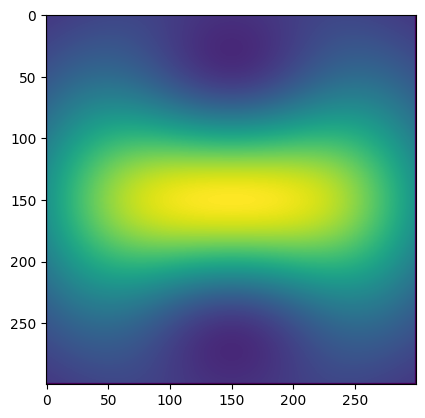

In [41]:
gCoeffs = [1, 1, 2, 3, 4]


    
    
plt.figure()
plt.imshow(mask)

In [20]:
gauss[0]

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.10859825, 0.11022297, ..., 0.1118608 , 0.11022297,
         0.        ],
        [0.        , 0.11022297, 0.11187199, ..., 0.11353433, 0.11187199,
         0.        ],
        ...,
        [0.        , 0.1118608 , 0.11353433, ..., 0.11522138, 0.11353433,
         0.        ],
        [0.        , 0.11022297, 0.11187199, ..., 0.11353433, 0.11187199,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

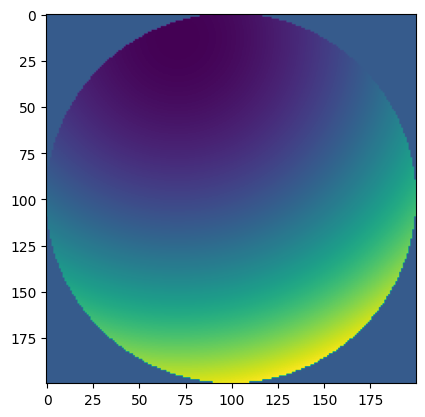

In [16]:
from aotools.functions import phaseFromZernikes
import matplotlib.pyplot as plt

vec = [1, 1, 3 ,1]
test = phaseFromZernikes(vec, 2 * 100)

plt.imshow(test)